# COVID Risk Estimation

In [1]:
!pip install -r requirements.txt -q

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons


## Estimating $T$
For our model of risk of catching covid-19, we will first need to estimate $T$, the probability of becoming infected with COVID-19 given an hour of contact. We can derive $T$ from $R_0$ since $$R_0=\bar{h}T\tau$$ where $\bar{h}$ is the average total contact hours per day and $\tau$ is the infectious period for a person with COVID-19.

For the original strain of COVID-19, $R_0$ was estimated to be $2.87$. 

As for $\tau$, acording to the CDC adults with COVID-19 remain infectious likely remain infectious for no longer than 10 days for mild to moderate cases or 20 days for sever cases after symptom onset. However Australian Department of Health also reports that "Pre symptomatic transmission can occur 1-3 days before symptom onset." Therefore, we will set $\tau$ to be around $14$ days.

Now for $\bar{h}$, a [study ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5554254/) of 1,149 Hong Kongnese participants found a average total contact hours of 11.46 hours. 

Of course all of these parameters can, and will be changed later, for now we will quickly define a function for calculating $T$ given $R_0$, $\bar{c}$, and $\tau$.

In [4]:
def T_estimate(R0=2.87,h_bar=11.46,tau=14):
    return R0/(h_bar*tau)

## Estimating Probability Of Contracting COVID-19
With our estimate of $T$ we can also estimate the probability of a person with $c$ contacts contracting covid every day $P_c$
$$P_c=1-\prod_{i=1}^c\left(1-P_I\left(1-(1-T)^{h_i}\right)\right)$$ Where $P_I$ is the probability that a given person has COVID-19 and $h_i$ is the number of hours spent interacting with the ith contact. Assuming that the number of hours spent interacting with each contact (ie $h_i=h$ for any $i$) is constant, this becomes $$P_c=1-\left(1-P_I\left(1-(1-T)^{h}\right)\right)^c$$

In [5]:
def P_contract(T,P_I,h,c=None):
    """
    T: a float for the probability of becoming infected with COVID-19 given an hour of contact
    P_I: a float for probability that a given person has COVID-19
    h: either an array of floats or a float. If h is an array, then the ith value is the number of hours
        spent interacting with the ith contact. If h is an float than it is the number of hours spent each contact
    c: (optional) a float the number of contacts a person has had, if h is a float, this is required
    """
    if type(h)==float:
        return 1-(1-P_I*(1-(1-T)**h))**c
    else:
        return 1-np.prod(1-np.tile(P_I,(h.shape[0],1)).T*(1-np.power(1-T,h)),axis=1)
    

## Mitigation Methods
For this notebook we will assume that mitigation methods would change T, the probability of becoming infected with COVID-19 given an hour of contact. To be specific, given $n$ mitigation methods:
$$T_{m}=T\prod_{i=1}^{n}(1-r_i)$$
Where $r_i$ is the reduction in risk due to the ith mitigation method

In [6]:
def calculate_T_reduced(T,reductions):
    return T*np.prod(1-reductions)

### Masks
Masks have been proven to significantly reduce COVID-19 infection. A study of the outbreak on board USS Theodore Roosevelt (CVN-71) found that face coverings was associated with "a 70% reduced risk". Other studies, such as one in Thailand and Beijing have found similar numbers, 77% and 79% reduction respectively. 
For now we will set $r_{mask}=0.7$

In [7]:
r_mask=0.7

### Vaccines
Currently there are three approved vaccines in the United Sates, the Pfizer-BioNTech vaccine, the Moderna vaccine, and the Johnsoon & Johnson vaccine. Against the original strain of COVID-19, they have 95%, 90% and 72% efficacy. So, for now we will set $r_{pfizer}=0.95$, $r_{moderna}=0.9$, and $r_{JJ}=0.72$

In [8]:
r_pfizer=0.95
r_moderna=0.9
r_JJ=0.72

## COVID Variants
Now we can introduce diffrent variants of COVID-19, these variants have higher $R_0$ (so as a result higher $T$). In particular, we will consider two variants:
- **Alpha Variant** This variant, first detected in Britian, has a $R_0$ of between $4$-$5$ (for now we will set $R_0=4.5$)
- **Delta Variant** This variant, first detected in India, has a $R_0$ of between $5$-$8$ (for now we will set $R_0=6.5$)


In [9]:
R0_delta=6.5
R0_alpha=4.5

### Vaccine effectivness Against Delta

There are some concerning Data regarding to the effectiveness of Vaccines (in particular the Pfizer vaccine) against Delta. For instance one preprint [study](https://www.medrxiv.org/content/10.1101/2021.08.06.21261707v1) found that the Pfizer and Moderna vaccines were only 42% and 76% effective against infection in July, when the Delta variant was dominant. 


In [10]:
r_pfizer_delta=0.42
r_moderna_delta=0.76

#### Three Dose Vaccine for the Delta Variant
However, acording to [Reuters](https://www.reuters.com/business/healthcare-pharmaceuticals/third-pfizer-dose-86-effective-over-60s-israeli-hmo-says-2021-08-18/) in initial results from an Israeli healthcare provider was the a third does of the Pfizer vaccine was found to be 86% effective.

In [11]:
r_pfizer_delta_3does=0.86

## Probability of Contracting COVID over a Longer Time Period
Up till now, we have been consider the probability of contracting covid in a day. However, what if we want to consider the risk of contracting COVID in a year, not a day? If the probability of Contracting COVID in a day is $p_d$, the probability of contracting COVID over a longer period of $t$ days is:
$$p_t=1-(1-p_d)^t$$

In [12]:
def P_catch_per_time_period(P_catch_per_day,n_days):
    return 1-(1-P_catch_per_day)**n_days

## Creating a Plot of the Probability of Contracting COVID
Below, we created an interactive plot of the probability of contracting COVID for a certain time period given the number of contracts per day. On the left side there are two boxes, one for the variant of COVID (either Delta, Alpha, or the Original Strain), and one for the mitigation methods (Mask and/or Vaccine). Below the plot there are four sliders:
- **Time Period** The time period (in days) over which we are calculating the probability of contracting COVID. (by default this is 180 days (so a school year)).
- **Active COVID Cases per 100k** This slider is in log scale so it is easier to tune for smaller number of active cases.
- **Average hours Interacting with each Contact** The average number of hours spent interacting with each contact.
- **Vaccine Effectiveness** The effectivness of the vaccine, ie: the reduction in risk for a person with the vaccine vs someone without.

<IPython.core.display.Javascript object>


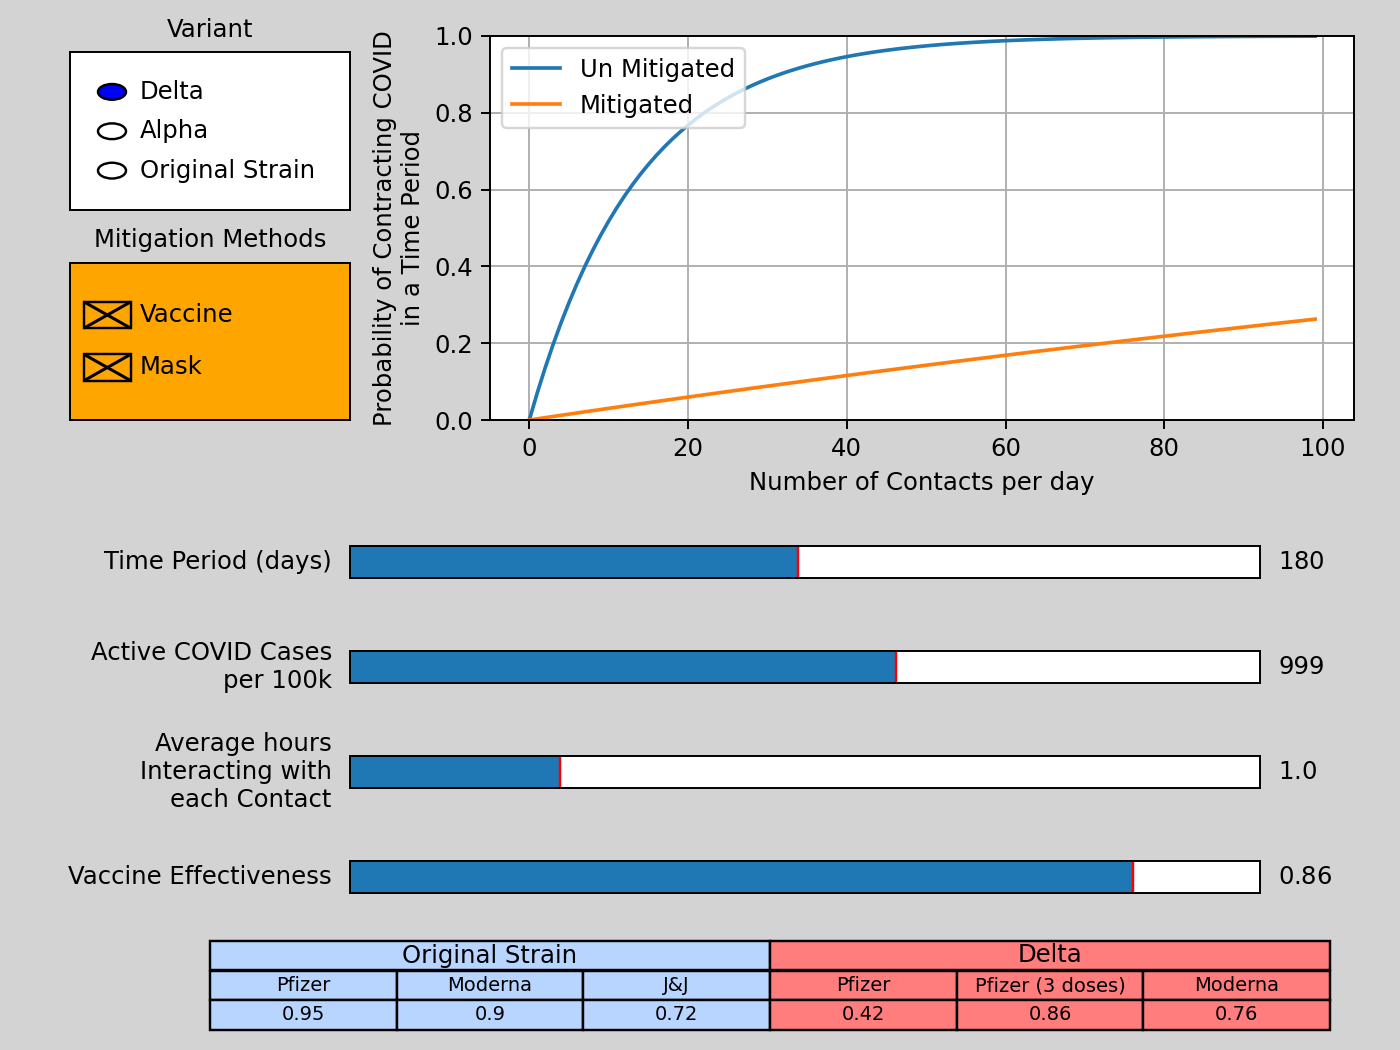

0

In [13]:
n_contacts=np.arange(100)

num_hours=1.0
COVID_concentration=0.01
r_vax=r_pfizer_delta_3does
mask=True
vax=True
variant="Delta"
time_period=180 #days

fig, ax = plt.subplots(figsize=(8,6),facecolor="lightgrey")
fig.tight_layout()
plt.subplots_adjust(left=0.35, bottom=0.6)


Oline,=plt.plot(n_contacts,
        P_catch_per_time_period(P_contract(T_estimate(R0=R0_delta),
                   COVID_concentration,num_hours,
                   c=n_contacts),time_period),label="Un Mitigated")

Mline,=plt.plot(n_contacts,
        P_catch_per_time_period(P_contract(calculate_T_reduced(T_estimate(R0=R0_delta),np.array([r_vax,r_mask])),
                   COVID_concentration,num_hours,
                   c=n_contacts),time_period),label="Mitigated")
plt.legend(loc="upper left")
plt.xlabel("Number of Contacts per day")
plt.ylabel("Probability of Contracting COVID\nin a Time Period")
plt.ylim(0,1)
plt.grid()

axCon = plt.axes([0.25, 0.35, 0.65, 0.03])
axHour = plt.axes([0.25, 0.25, 0.65, 0.03])
axTime = plt.axes([0.25, 0.45, 0.65, 0.03])

axVax = plt.axes([0.25, 0.15, 0.65, 0.03])

axVar = plt.axes([0.05, 0.8, 0.2, 0.15])
axVar.text(0.5,1.1,"Variant",ha="center")

axMit = plt.axes([0.05, 0.6, 0.2, 0.15],facecolor="orange")
axMit.text(0.5,1.1,"Mitigation Methods",ha="center")

sCon = Slider(axCon, 'Active COVID Cases\nper 100k', 
              np.log(1), np.log(10**5), valinit=np.log(COVID_concentration*10**5))
sCon.valtext.set_text(int(COVID_concentration*10**5))

sHour = Slider(axHour, 'Average hours\nInteracting with\neach Contact', 
              0.1, 4, valinit=num_hours)

sVax= Slider(axVax, "Vaccine Effectiveness",
            0,1,valinit=r_pfizer_delta_3does)

sTime= Slider(axTime,"Time Period (days)",1,365,valinit=time_period)


Variant_radio=RadioButtons(axVar, ('Delta', 'Alpha', 'Original Strain'))

Mitigation_checkbox=CheckButtons(axMit, ["Vaccine","Mask"], [vax,mask])

axVarTabel = plt.axes([0.15, 0.075, 0.8, 0.03])
axVarTabel.axis('tight')
axVarTabel.axis('off')
axVarTabel.table([["Original Strain","Delta"]],loc='center',
                 cellLoc='center',cellColours=[["#b8d5ff","#ff7d7d"]])
axVarTabel.table([["Pfizer","Moderna","J&J","Pfizer","Pfizer (3 doses)","Moderna"],
                 [r_pfizer,r_moderna,r_JJ,r_pfizer_delta,r_pfizer_delta_3does,r_moderna_delta]]
                 ,loc='bottom',cellLoc='center',cellColours=2*[3*["#b8d5ff"]+3*["#ff7d7d"]])

def set_variant(label):
    global variant
    variant=label
    update(0)
    
def set_mitigation(label):
    global vax, mask
    
    if label=="Vaccine":
        vax=not vax
    if label=="Mask":
        mask=not mask
    update(0)
    
def update(val):
    
    Concentration = np.exp(sCon.val)/10**5
    sCon.valtext.set_text(int(Concentration*10**5))
    num_hours=float(sHour.val)
    r_vax=sVax.val
    time_period=sTime.val
    
    if variant=="Delta":
        T=T_estimate(R0=R0_delta)
    if variant=="Alpha":
        T=T_estimate(R0=R0_alpha)
    if variant=="Original Strain":
        T=T_estimate()
    
    Mitigations=[]
    if vax:
        Mitigations.append(r_vax)
    if mask:
        Mitigations.append(r_mask)
        
    Oline.set_ydata(P_catch_per_time_period(P_contract(T,
                   Concentration,num_hours,
                   c=n_contacts),time_period))
    
    Mline.set_ydata(P_catch_per_time_period(
        P_contract(calculate_T_reduced(T,np.array([Mitigations])),
                   Concentration,num_hours,
                   c=n_contacts),time_period))
    
    fig.canvas.draw_idle()

Mitigation_checkbox.on_clicked(set_mitigation)
Variant_radio.on_clicked(set_variant)
sCon.on_changed(update)  
sHour.on_changed(update)
sVax.on_changed(update)
sTime.on_changed(update)

In [ ]:
#hide code
#from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')